The default Hydra config for inference is set in src/configs/inference.yaml

The destination folder is cleared (if it exists)

In [34]:
!python inference.py

1it [00:09,  9.44s/it]
DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
           

Visualise the entire pianoroll for the audio recording

In [35]:
min_pitch = 24
max_pitch = 96
midi_pitchs = 128

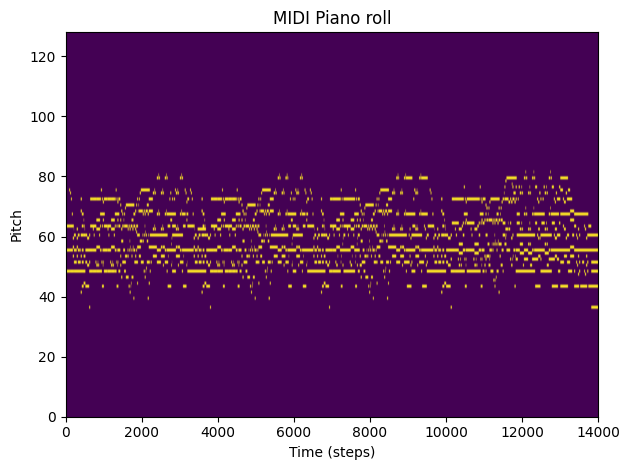

In [36]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from scipy.sparse import csr_matrix, save_npz,load_npz
# Загрузка данных
midi_data = load_npz("SWD/Schubert_D911-01_SC06.npz").toarray()
plt.imshow(midi_data.T, aspect='auto', origin='lower',cmap='viridis',
           extent=[0, midi_data.shape[0], 0, midi_pitchs])
plt.xlabel('Time (steps)')
plt.ylabel('Pitch')
plt.title('MIDI Piano roll')
plt.tight_layout()
plt.show()

In [37]:
print(midi_data.shape)

(14011, 128)


Let's build an alignment

In [38]:
import glob
import re
from pathlib import Path
import torch
saved_folder = "data/saved/predict/val"
dir_path = Path(saved_folder).absolute()
if not dir_path.exists():
        raise FileNotFoundError(f"Directory {dir_path} not exists")
pth_files = glob.glob(str(dir_path / "*.pth"))
pth_files = sorted(pth_files, key=lambda x: int(re.search(r'\d+', x).group()))
predict = []
for file_path in pth_files:
        print(Path(file_path).relative_to(dir_path))
        data = torch.load(file_path)
        predict.append(data['predicted probabilities'])
predict = torch.cat(predict, dim = 1)

output_0.pth
output_1.pth
output_2.pth
output_3.pth
output_4.pth
output_5.pth
output_6.pth
output_7.pth
output_8.pth
output_9.pth
output_10.pth
output_11.pth
output_12.pth
output_13.pth
output_14.pth
output_15.pth
output_16.pth
output_17.pth
output_18.pth
output_19.pth
output_20.pth
output_21.pth
output_22.pth
output_23.pth
output_24.pth
output_25.pth
output_26.pth
output_27.pth
output_28.pth
output_29.pth
output_30.pth


Let's look at prediction

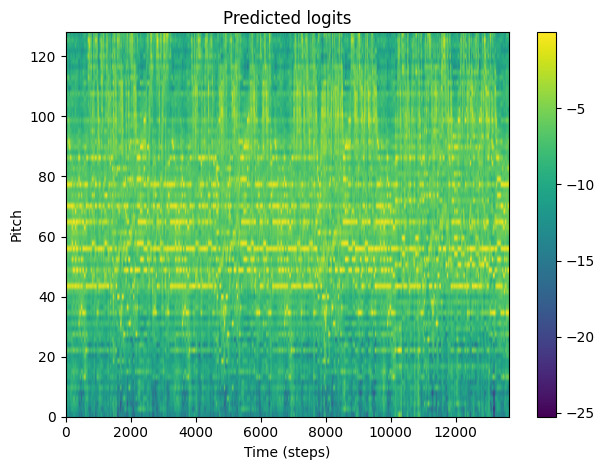

torch.Size([2, 13640, 73])


In [39]:
plt.imshow(predict[1,:,1:].T, aspect='auto', origin='lower',cmap='viridis',
           extent=[0, predict.shape[1], 0, midi_pitchs])
plt.xlabel('Time (steps)')
plt.ylabel('Pitch')
plt.title('Predicted logits')
plt.tight_layout()
plt.colorbar()
plt.show()
print(predict.shape)

The records have different sizes due to the way the edge cases are handled

Besides, because the alignment does not work very fast, let's take some small interval (for example, 3 minutes)

In [40]:
from src.metrics.alignment_metric import AlignmentMetric
max_time = 44*60*4
predict = predict[:,:max_time]
midi_data = midi_data[:max_time,min_pitch:max_pitch]
metric = AlignmentMetric(
    save_alignment = True
    
)
TP,FP,FN = metric(predict.unsqueeze(0),torch.tensor(midi_data).unsqueeze(0))
recall = 0
precision = 0
f1 = 0
if TP > 0:
    recall = (TP)/(TP + FN)
    precision = TP / (TP + FP)
    f1 = 2.0 * precision * recall / (precision + recall)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1: {f1}")

Recall: 0.8937874130399611
Precision: 0.9112577319587629
F1: 0.902438028341569


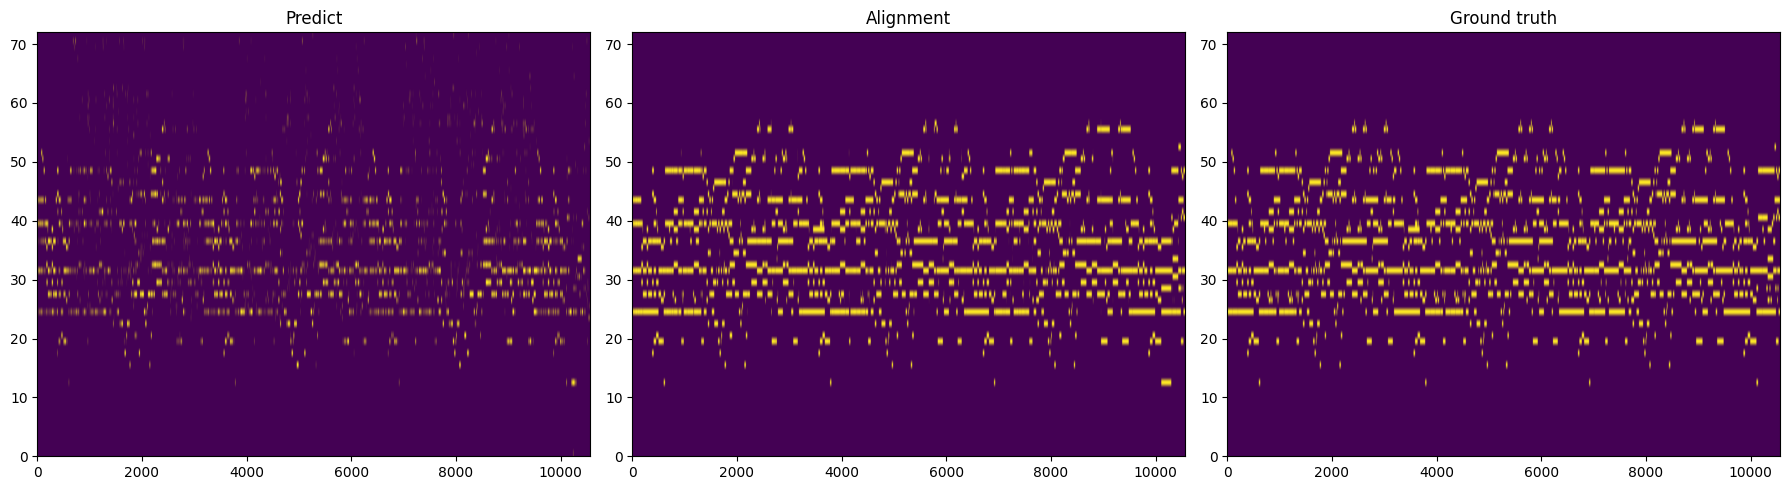

In [45]:
aligned_audio = metric.get_alignment()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
real_predict = predict[1,:,1:]
im1 = ax1.imshow((np.exp(real_predict.T) > 0.5).to(int),aspect='auto', origin='lower',cmap='viridis',
extent=[0, aligned_audio.shape[0], 0, max_pitch - min_pitch])
ax1.set_title("Predict")
im2 = ax2.imshow(aligned_audio.T, aspect='auto', origin='lower',cmap='viridis',
extent=[0, aligned_audio.shape[0], 0, max_pitch - min_pitch])
ax2.set_title("Alignment")
im3 = ax3.imshow(midi_data.T, aspect='auto', origin='lower',cmap='viridis',
extent=[0, aligned_audio.shape[0], 0, max_pitch - min_pitch])
ax3.set_title("Ground truth") 
plt.tight_layout()
plt.show()

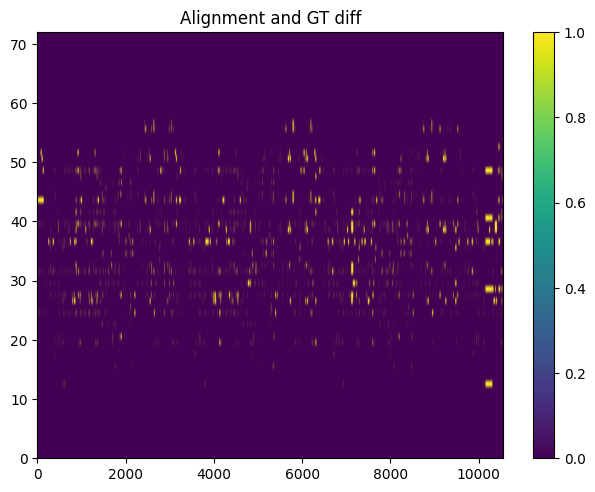

In [44]:
diff = aligned_audio.T - midi_data.T
plt.imshow(abs(diff),aspect='auto', origin='lower',cmap='viridis',
extent=[0, aligned_audio.shape[0], 0, max_pitch - min_pitch])
plt.tight_layout()
plt.title("Alignment and GT diff")
plt.colorbar()
plt.show()